Skład grupy:
    Paweł Awramiuk
    Anna Chojnowska
    Piotr Grusza
    Szymon Leszczyński

In [1]:
## Polecenia do instalacji pakietów
# conda install -c conda-forge tensorflow
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Konfiguracje globalne
# Formatowanie liczb w DataFrame
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
data_AUG = pd.read_csv("apartments_pl_2023_08.csv")
data_SEP = pd.read_csv("apartments_pl_2023_09.csv")
data_OCT = pd.read_csv("apartments_pl_2023_10.csv")

In [3]:
data_AUG.drop(columns=["id"], inplace=True)
data_AUG.drop(columns=["schoolDistance","clinicDistance","postOfficeDistance","kindergartenDistance","restaurantDistance","collegeDistance","pharmacyDistance"], inplace=True)
data_AUG.drop(columns=["buildingMaterial","condition"], inplace=True)

data_SEP.drop(columns=["id"], inplace=True)
data_SEP.drop(columns=["schoolDistance","clinicDistance","postOfficeDistance","kindergartenDistance","restaurantDistance","collegeDistance","pharmacyDistance"], inplace=True)
data_SEP.drop(columns=["buildingMaterial","condition"], inplace=True)

data_OCT.drop(columns=["id"], inplace=True)
data_OCT.drop(columns=["schoolDistance","clinicDistance","postOfficeDistance","kindergartenDistance","restaurantDistance","collegeDistance","pharmacyDistance"], inplace=True)
data_OCT.drop(columns=["buildingMaterial","condition"], inplace=True)


data_SEP.drop_duplicates(inplace = True)
data_AUG.drop_duplicates(inplace = True)
data_OCT.drop_duplicates(inplace = True)

Na podstawie wcześniejszej analizy usuwamy kolumny: "schoolDistance","clinicDistance","postOfficeDistance","kindergartenDistance","restaurantDistance","collegeDistance","pharmacyDistance", gdyż są one silnie ze sobą skorelowane, a w danych występuje dodatkowa zależna od nich kolumna "poiCount". Usuwamy również kolumnę "id" zawierającą unikatowy identyfikator wiersza, oraz ze względu na wysoki procent braków w rekordach kolumny "buildingMaterial" i "condition"

In [4]:
missing_values = pd.concat([
        data_AUG.isna().sum(),
        data_AUG.isna().sum() / len(data_AUG) * 100,
        data_SEP.isna().sum(),
        data_SEP.isna().sum() / len(data_SEP) * 100,
        data_OCT.isna().sum(),
        data_OCT.isna().sum() / len(data_OCT) * 100
    ],
    axis=1
)
missing_values.rename(columns = {0:'AUG', 1:'AUG %',2:'SEP', 3:'SEP %',4:'OCT', 5:'OCT %',6:'ALL', 7:'ALL %'}, inplace = True)
missing_values

,AUG,AUG %,SEP,SEP %,OCT,OCT %
city,0,0.00,0,0.00,0,0.00
type,3983,21.31,3764,22.40,3727,22.56
squareMeters,0,0.00,0,0.00,0,0.00
rooms,0,0.00,0,0.00,0,0.00
floor,3392,18.15,3003,17.87,3017,18.26
floorCount,259,1.39,243,1.45,242,1.46
buildYear,3223,17.25,2903,17.27,2879,17.43
latitude,0,0.00,0,0.00,0,0.00
longitude,0,0.00,0,0.00,0,0.00
centreDistance,0,0.00,0,0.00,0,0.00


<Axes: >

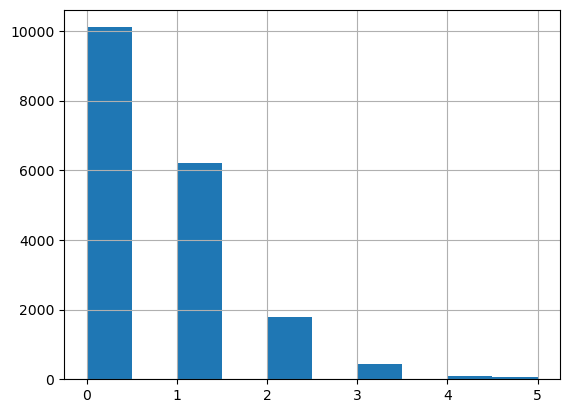

In [5]:
data_AUG.isna().sum(1).hist()

<Axes: >

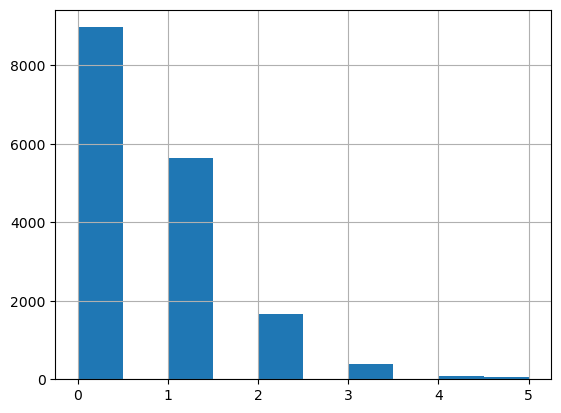

In [6]:
data_SEP.isna().sum(1).hist()

<Axes: >

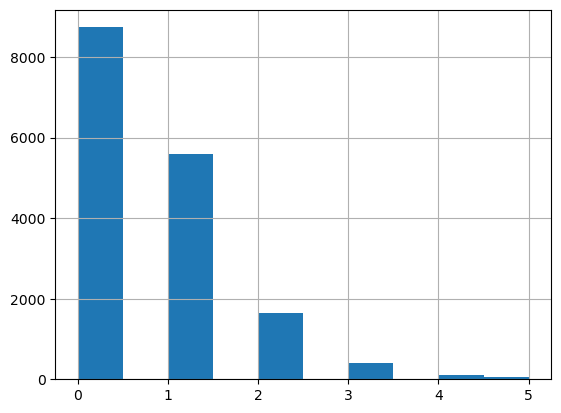

In [7]:
data_OCT.isna().sum(1).hist()

In [8]:
data_AUG = data_AUG.loc[(data_AUG.isna().sum(axis=1)<3)]
data_SEP = data_SEP.loc[(data_SEP.isna().sum(axis=1)<3)]
data_OCT = data_OCT.loc[(data_OCT.isna().sum(axis=1)<3)]

Ze względu na niski odsetek rekordów posiadajacych więcej, niż dwa braki, oferty takie zostały usunięte, celem łatwiejszej obsługi braków w ofertach.

In [9]:
def show_missing_values(data):
    missing_values = pd.concat([
        data.isna().sum(),
        data.isna().sum() / len(data) * 100
    ],axis=1)
    missing_values.rename(columns = {0:'MISSING', 1:'MISSING %'}, inplace = True)
    print(missing_values)

In [10]:
missing_values = pd.concat([
        data_AUG.isna().sum(),
        data_AUG.isna().sum() / len(data_AUG) * 100,
        data_SEP.isna().sum(),
        data_SEP.isna().sum() / len(data_SEP) * 100,
        data_OCT.isna().sum(),
        data_OCT.isna().sum() / len(data_OCT) * 100
    ],
    axis=1
)
missing_values.rename(columns = {0:'AUG', 1:'AUG %',2:'SEP', 3:'SEP %',4:'OCT', 5:'OCT %',6:'ALL', 7:'ALL %'}, inplace = True)
missing_values

,AUG,AUG %,SEP,SEP %,OCT,OCT %
city,0,0.00,0,0.00,0,0.00
type,3483,19.25,3312,20.36,3249,20.35
squareMeters,0,0.00,0,0.00,0,0.00
rooms,0,0.00,0,0.00,0,0.00
floor,2979,16.47,2630,16.17,2631,16.48
floorCount,54,0.30,42,0.26,41,0.26
buildYear,2719,15.03,2465,15.16,2428,15.21
latitude,0,0.00,0,0.00,0,0.00
longitude,0,0.00,0,0.00,0,0.00
centreDistance,0,0.00,0,0.00,0,0.00


In [11]:
import missingno as msno

<Axes: >

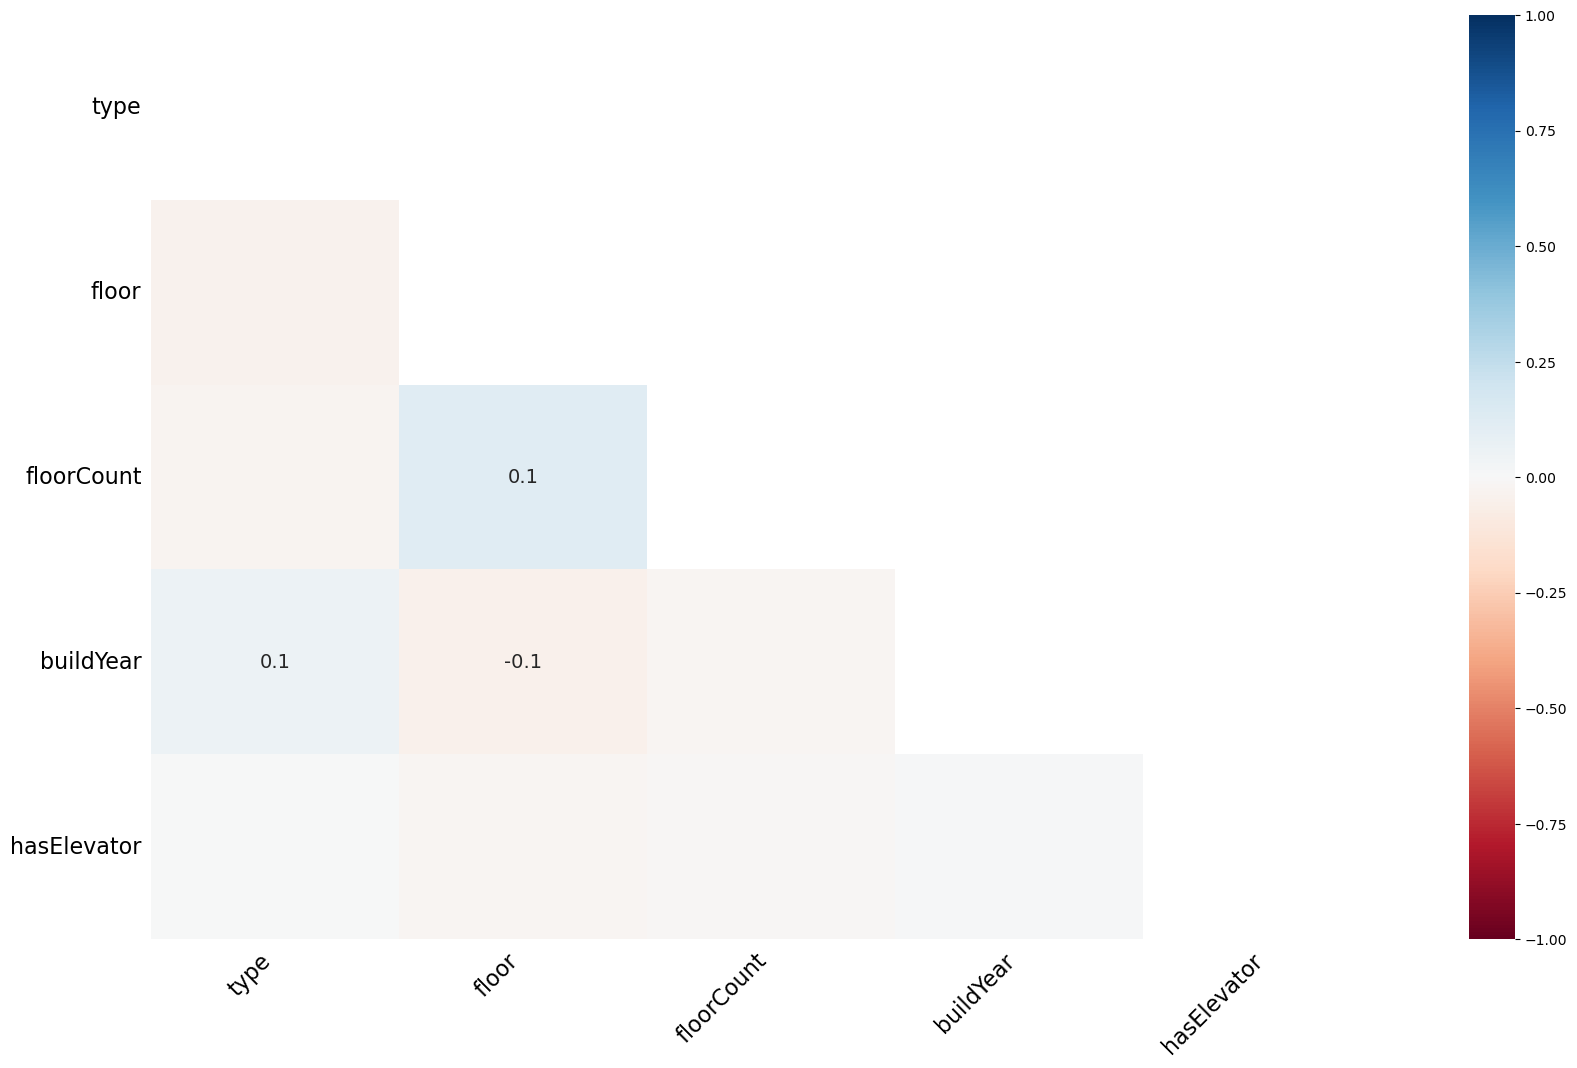

In [12]:
msno.heatmap(data_AUG)

<Axes: >

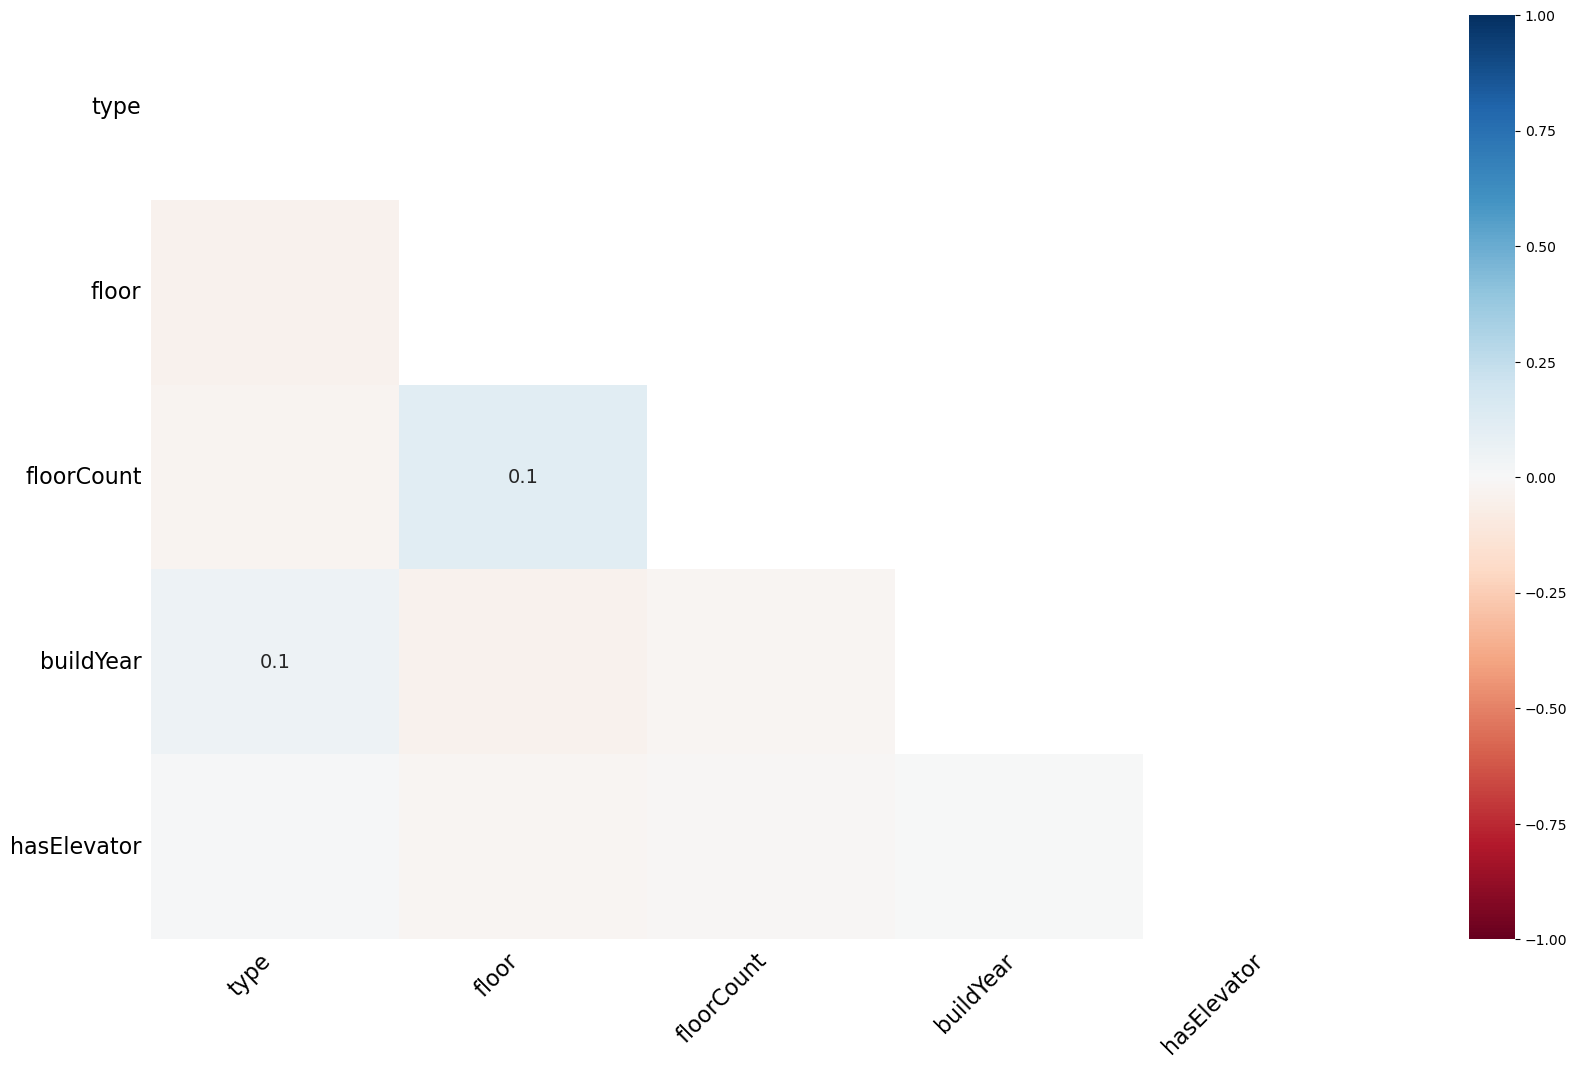

In [13]:
msno.heatmap(data_SEP)

<Axes: >

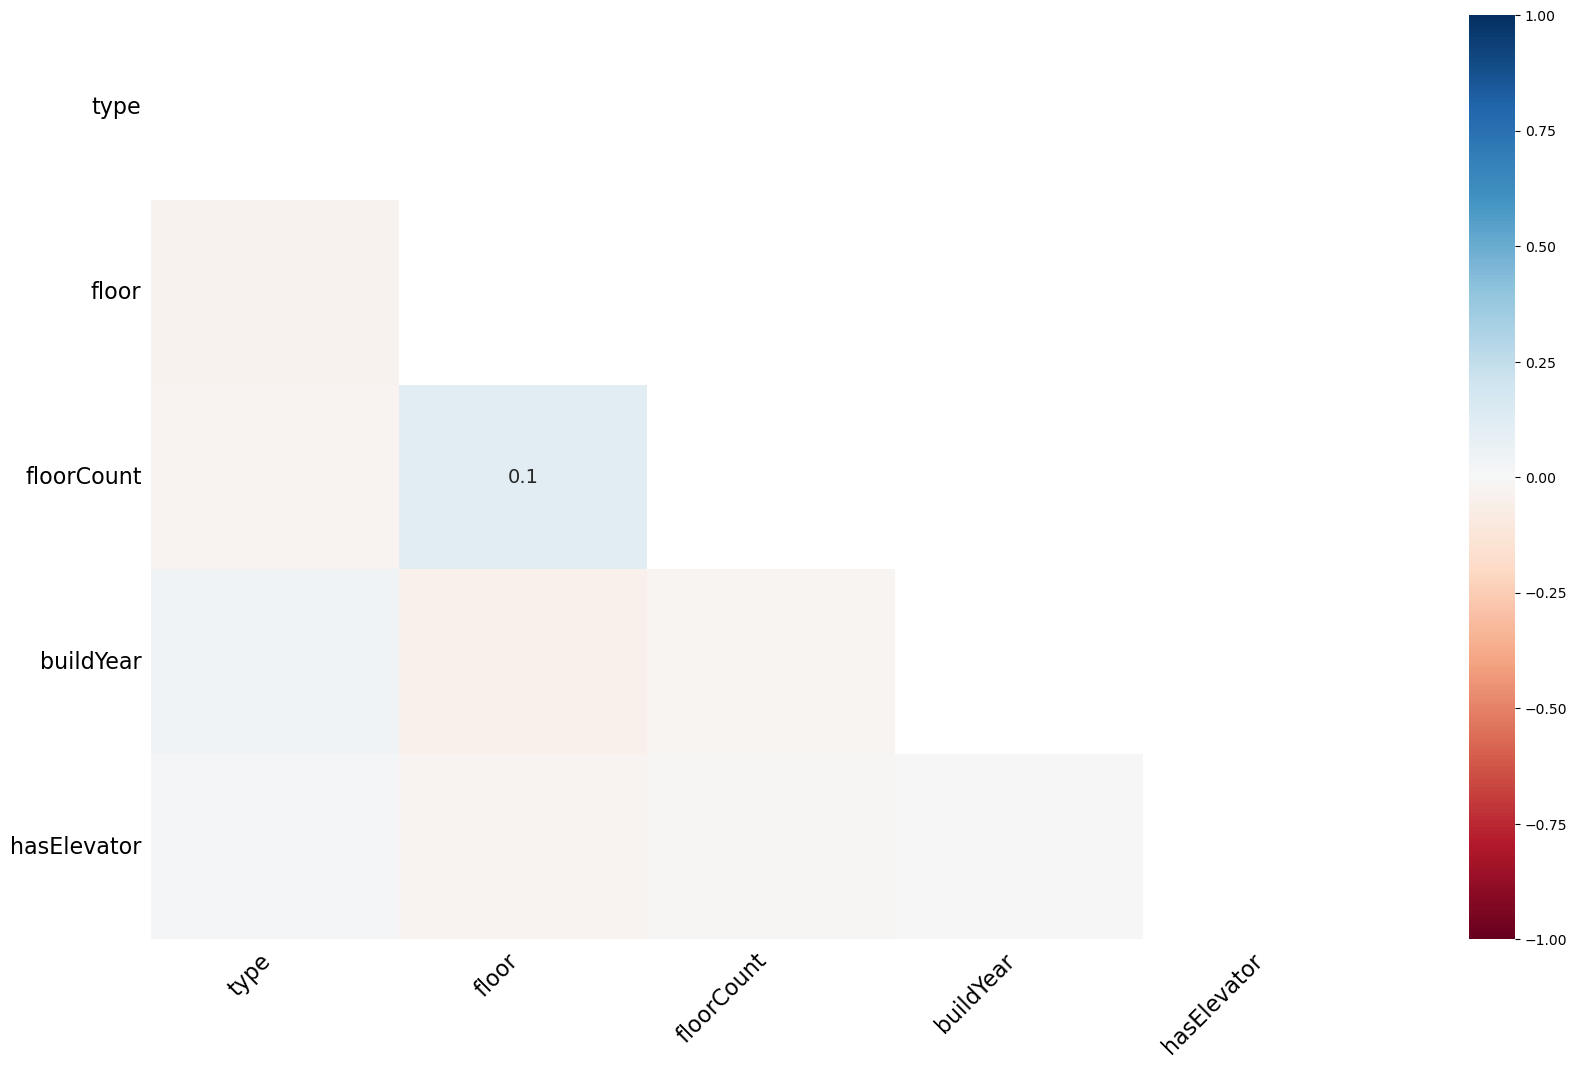

In [14]:
msno.heatmap(data_OCT)

In [15]:
# TODO: wniosek - z artykułu z kaggle, niska korelacja może wskazywać, że to MAR
# Missing at Random (MAR)
# MAR occurs when the missingness is not random, but where missingness can be 
# fully accounted for by variables where there is complete information.

Powyższe wykresy wskazują na to, że nie występuje korelacja pomiędzy brakującymi danymi w poszczególnych miesiąca, co może oznaczać, że mamy do czynienia z brakami "Missing at Random".

## Przypisanie miesiąca do poszczególnych ofert na podstawie pliku, z którego pochodzą dane

In [16]:
# dodanie miesiąca, w którym dana oferta sprzedaży była dostępna (wszystkie dane pochodzą z roku 2023)
data_AUG["offerMonth"] = 8
data_SEP["offerMonth"] = 9
data_OCT["offerMonth"] = 10

Do każdej oferty dodajemy informację o miesiącu, z którego pochodzi, co po złączeniu plików da nam informację o trendach zmian cen w danym przedziale czasu.

# Obsługa brakujących danych

In [17]:
# TODO Wypełnienie braków (type, buildYear, floor, floorCount, hasElevator)
# type, buildYear - raczej trudno uzupełnić, niska korelacja z ceną, usunąć kolumnę(?)
# floorCount -> usunąć wiersze (?) to tylko kilkadziesiąt ofert, 
# hasElevator można ustawić na podstawie floorCount, powinno być dość zgodnie z rzeczywistością,
# floor (?) może usunąć kolumnę, niemal zerowa korelacja z ceną, a i tak mamy sporo innych zmiennych

W przypadku brakujących danych, które zostaną uzupełnione wartościami średnimi lub medianą, operacje zostaną wykonane oddzielnie w obrębie poszczególnych miesięcy, aby uzupełnione oferty, były bardziej zbliżone do innych ofert wystawionych w podobnym czasie.

Uzupełnienie danych w kolumnach, w których wartości zostaną uzupełnione na podstawie innych kolumn/wiedzy dziedzinowej zostanie wykonane po wcześniejszym połączeniu danych w jeden DataFrame.

## type

## floor

## floorCount

## buildYear

In [18]:
data_AUG.fillna(data_AUG.median(numeric_only=True), inplace=True)
data_SEP.fillna(data_SEP.median(numeric_only=True), inplace=True)
data_OCT.fillna(data_OCT.median(numeric_only=True), inplace=True)

In [19]:
# TODO obsługa odchyłek (outliers)
# z wykresów z analizy wygląda, że warto rozpatrzyć tutaj zmienne: 
# "floor", "buildYear", "poiCount", "ownership"
# dodatkowo "ownership" pewnie stałoby się zmienną kategoryczną z 2-ma wartościami + silnie przeważa 'condominium', wiec moze warto usunac kolumne

In [20]:
# TODO przystosowanie istniejących kolumn (np. one-hot encoding dla danych dyskretnych,. normalizacja danych ciągłych)

## Złączenie danych

In [21]:
data_ALL = pd.concat([data_AUG, data_SEP, data_OCT], ignore_index=True)

In [22]:
data_ALL.tail()

,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,ownership,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,offerMonth
50318,bydgoszcz,NaN,50.12,2.00,1.00,1.00,1992.00,53.13,18.00,0.88,42.00,condominium,yes,no,no,no,no,360000,10
50319,bydgoszcz,tenement,100.00,4.00,3.00,4.00,1910.00,53.13,18.01,0.65,54.00,condominium,yes,yes,no,no,yes,590000,10
50320,bydgoszcz,tenement,59.10,2.00,1.00,1.00,1910.00,53.13,18.01,0.65,54.00,condominium,yes,no,no,no,yes,320000,10
50321,bydgoszcz,NaN,81.07,5.00,1.00,4.00,2019.00,53.12,17.96,3.04,9.00,condominium,no,yes,yes,no,no,679000,10
50322,bydgoszcz,blockOfFlats,133.16,4.00,3.00,3.00,1992.00,53.11,17.99,1.32,9.00,condominium,no,yes,no,no,yes,925000,10


In [23]:
data_ALL.count()

city               50323
type               40279
squareMeters       50323
rooms              50323
floor              50323
floorCount         50323
buildYear          50323
latitude           50323
longitude          50323
centreDistance     50323
poiCount           50323
ownership          50323
hasParkingSpace    50323
hasBalcony         50323
hasElevator        48750
hasSecurity        50323
hasStorageRoom     50323
price              50323
offerMonth         50323
dtype: int64

<Axes: >

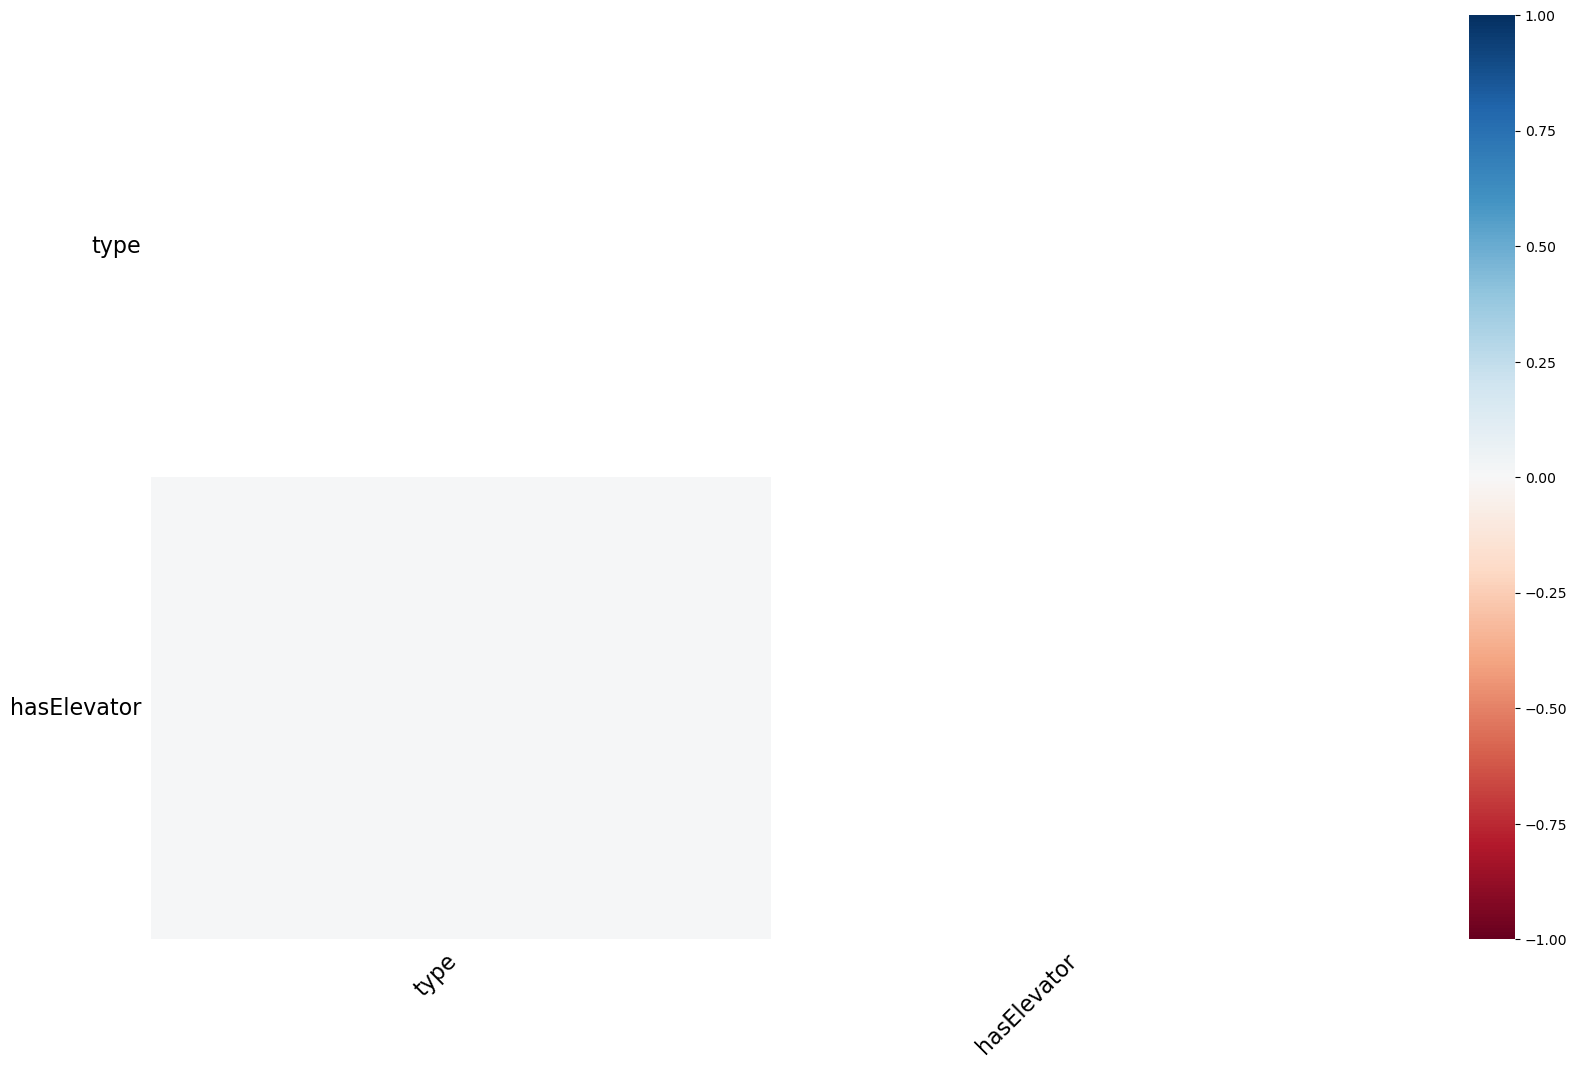

In [24]:
msno.heatmap(data_ALL)

## hasElevator

https://isap.sejm.gov.pl/isap.nsf/download.xsp/WDU20190001065/O/D20191065.pdf
**Dział III Rozdział 1 Paragraf 54**

In [25]:
print("hasElevator NA ALL:" + str(data_ALL["hasElevator"].isna().sum()))

hasElevator NA ALL:1573


Budynki mieszkalne mające więcej niż 4 piętra wymagają windy

In [26]:
filt = (data_ALL["floorCount"] > 4)
new_val = data_ALL.loc[filt, ["hasElevator"]].fillna("yes", axis=1)
data_ALL.loc[filt, ["hasElevator"]] = new_val

W budynkach mających 4 lub mniej pięter parametr określający obecność windy ustawiany jest na wartość: "nie"

In [27]:
filt = ((data_ALL["floorCount"] <= 4) & (data_ALL["floorCount"].notnull()))
new_val = data_ALL.loc[filt, ["hasElevator"]].fillna("no", axis=1)
data_ALL.loc[filt, ["hasElevator"]] = new_val

In [28]:
print("hasElevator NA ALL:" + str(data_ALL["hasElevator"].isna().sum()))

hasElevator NA ALL:0


## city - one-hot encoding

"city" jest zmienną teskstową kategoryczną o liczności 15. Z tego powodu zostanie zakodowana metodą one-hot.

In [29]:
data_ALL = pd.get_dummies(data_ALL, columns=["city"], prefix="city")
data_ALL

,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,...,city_katowice,city_krakow,city_lodz,city_lublin,city_poznan,city_radom,city_rzeszow,city_szczecin,city_warszawa,city_wroclaw
0,blockOfFlats,63.00,3.00,4.00,10.00,1980.00,53.38,14.63,6.53,9.00,...,0,0,0,0,0,0,0,1,0,0
1,blockOfFlats,36.00,2.00,8.00,10.00,1990.00,53.44,14.56,2.15,16.00,...,0,0,0,0,0,0,0,1,0,0
2,tenement,73.02,3.00,2.00,3.00,1990.00,53.45,14.55,3.24,9.00,...,0,0,0,0,0,0,0,1,0,0
3,tenement,87.60,3.00,2.00,3.00,1990.00,53.44,14.53,2.27,32.00,...,0,0,0,0,0,0,0,1,0,0
4,blockOfFlats,66.00,3.00,1.00,3.00,1990.00,53.41,14.50,4.07,1.00,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50318,NaN,50.12,2.00,1.00,1.00,1992.00,53.13,18.00,0.88,42.00,...,0,0,0,0,0,0,0,0,0,0
50319,tenement,100.00,4.00,3.00,4.00,1910.00,53.13,18.01,0.65,54.00,...,0,0,0,0,0,0,0,0,0,0
50320,tenement,59.10,2.00,1.00,1.00,1910.00,53.13,18.01,0.65,54.00,...,0,0,0,0,0,0,0,0,0,0
50321,NaN,81.07,5.00,1.00,4.00,2019.00,53.12,17.96,3.04,9.00,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# TODO: jeśli [type, condition, buildingMaterial, ownership] nie zostana wczesniej usuniete, to tez moga zostac zakodowane one-hot, bo maja po 3-4 wartosci

## Konwersja zmiennych 2-wartościowych na typ boolean

In [31]:
# TODO: Mysle, ze warto zamienic yes/no, na boolean, albo 0/1
# Do konca nie wiem czy mialoby to na cos wplyw.

In [32]:
data_ALL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50323 entries, 0 to 50322
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              40279 non-null  object 
 1   squareMeters      50323 non-null  float64
 2   rooms             50323 non-null  float64
 3   floor             50323 non-null  float64
 4   floorCount        50323 non-null  float64
 5   buildYear         50323 non-null  float64
 6   latitude          50323 non-null  float64
 7   longitude         50323 non-null  float64
 8   centreDistance    50323 non-null  float64
 9   poiCount          50323 non-null  float64
 10  ownership         50323 non-null  object 
 11  hasParkingSpace   50323 non-null  object 
 12  hasBalcony        50323 non-null  object 
 13  hasElevator       50323 non-null  object 
 14  hasSecurity       50323 non-null  object 
 15  hasStorageRoom    50323 non-null  object 
 16  price             50323 non-null  int64 

In [33]:
columns_to_convert = ["hasParkingSpace", "hasBalcony", "hasElevator", "hasSecurity", "hasStorageRoom"]

In [34]:
for i in columns_to_convert:
    data_ALL[i] = data_ALL[i].map({'yes': 1, 'no': 0})

In [35]:
data_ALL[columns_to_convert]

,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom
0,1,1,1,0,1
1,0,1,1,0,1
2,0,0,0,0,0
3,1,1,0,0,1
4,0,0,0,0,0
...,...,...,...,...,...
50318,1,0,0,0,0
50319,1,1,0,0,1
50320,1,0,0,0,1
50321,0,1,1,0,0


In [36]:
data_ALL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50323 entries, 0 to 50322
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              40279 non-null  object 
 1   squareMeters      50323 non-null  float64
 2   rooms             50323 non-null  float64
 3   floor             50323 non-null  float64
 4   floorCount        50323 non-null  float64
 5   buildYear         50323 non-null  float64
 6   latitude          50323 non-null  float64
 7   longitude         50323 non-null  float64
 8   centreDistance    50323 non-null  float64
 9   poiCount          50323 non-null  float64
 10  ownership         50323 non-null  object 
 11  hasParkingSpace   50323 non-null  int64  
 12  hasBalcony        50323 non-null  int64  
 13  hasElevator       50323 non-null  int64  
 14  hasSecurity       50323 non-null  int64  
 15  hasStorageRoom    50323 non-null  int64  
 16  price             50323 non-null  int64 